In [1]:
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from tqdm import trange
from sklearn.preprocessing import StandardScaler
import time

In [2]:
data = load_boston()
df = pd.DataFrame(data["data"], columns = data["feature_names"])
df["target"] = data["target"]
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [3]:
X = np.array(df.drop(columns = "target"))
y = np.array(df["target"])

In [4]:
class Model(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, output_size)
    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.relu(self.fc3(x))
        return x

100%|██████████| 200/200 [00:02<00:00, 73.04it/s]


score :  33.182403564453125


100%|██████████| 200/200 [00:02<00:00, 73.31it/s]


score :  631.9144897460938


100%|██████████| 200/200 [00:03<00:00, 66.60it/s]


score :  26.41788101196289


100%|██████████| 200/200 [00:02<00:00, 70.29it/s]


score :  23.094478607177734


100%|██████████| 200/200 [00:02<00:00, 76.44it/s]


score :  19.66415023803711


100%|██████████| 200/200 [00:02<00:00, 73.36it/s]


score :  29.543590545654297


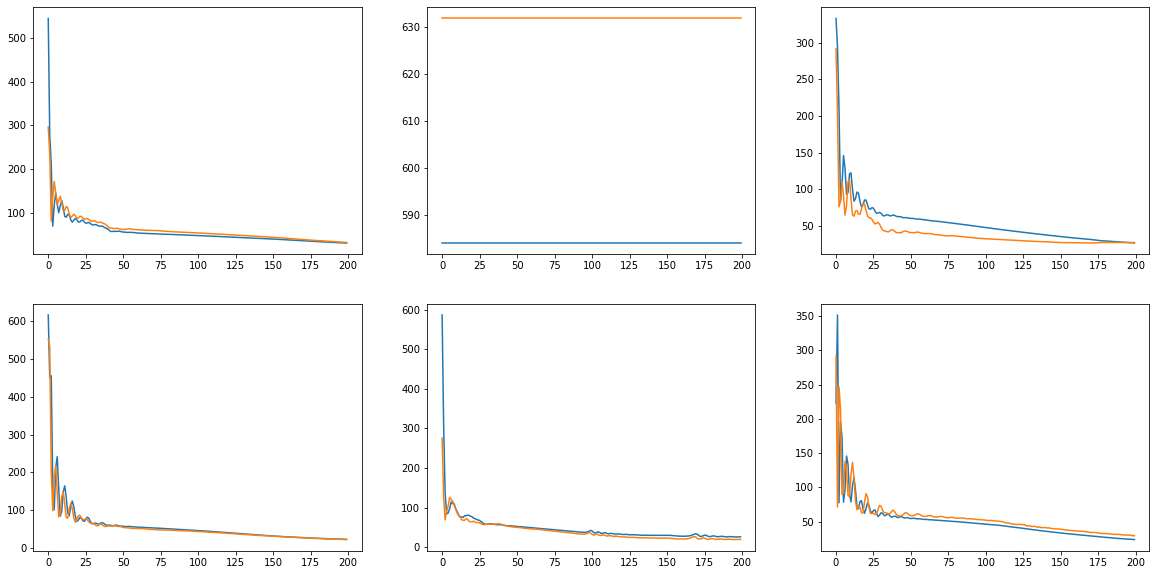

In [5]:
criterion = nn.MSELoss()
scaler = StandardScaler()
kf = KFold(n_splits = 6, shuffle = True)
plt.figure(figsize = (20, 10))
for i, (train_idx, valid_idx) in enumerate(kf.split(X, y)):
    X_train = X[train_idx]
    X_valid = X[valid_idx]
    X_train_num = scaler.fit_transform(X_train)
    X_valid_num = scaler.transform(X_valid)
    X_train = torch.from_numpy(X_train).float()
    X_valid = torch.from_numpy(X_valid).float()
    y_train = torch.from_numpy(y[train_idx]).float()
    y_valid = torch.from_numpy(y[valid_idx]).float()
    model = Model(X_train.shape[1], 1)
    optimizer = torch.optim.Adam(model.parameters())
    fold_loss = {"train" : [], "valid" : []}
    for epoch in trange(200):
        model.train()
        optimizer.zero_grad()
        pred = model(X_train)
        pred = torch.flatten(pred)
        loss = criterion(pred, y_train)
        fold_loss["train"].append(loss.item())
        loss.backward()
        optimizer.step()
        model.eval()
        with torch.no_grad():
            pred = model(X_valid)
            pred = torch.flatten(pred)
            loss = criterion(pred, y_valid)
        fold_loss["valid"].append(loss.item())
    print("score : ", min(fold_loss["valid"]))
    plt.subplot(2, 3, i+1)
    plt.plot(fold_loss["train"])
    plt.plot(fold_loss["valid"])
    time.sleep(1)
plt.show()